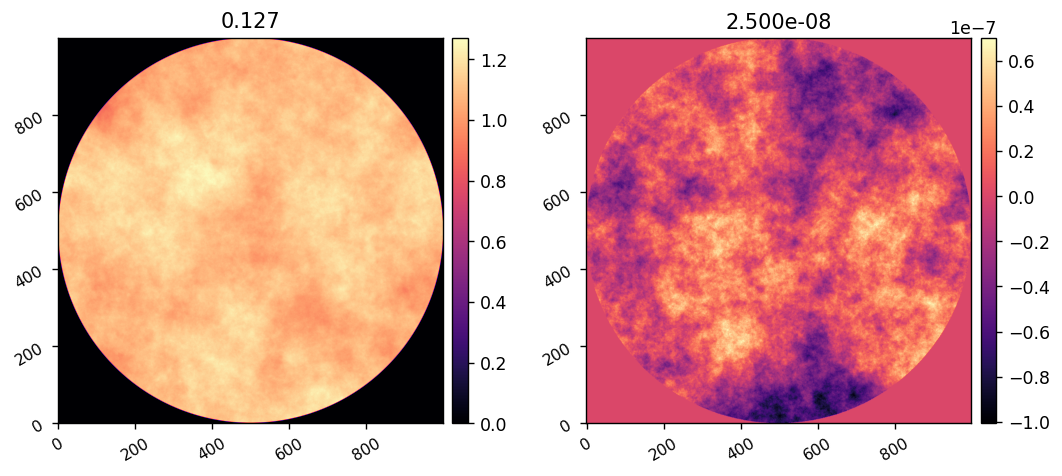

array(2.5e-08)

In [78]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob_2 as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])



influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


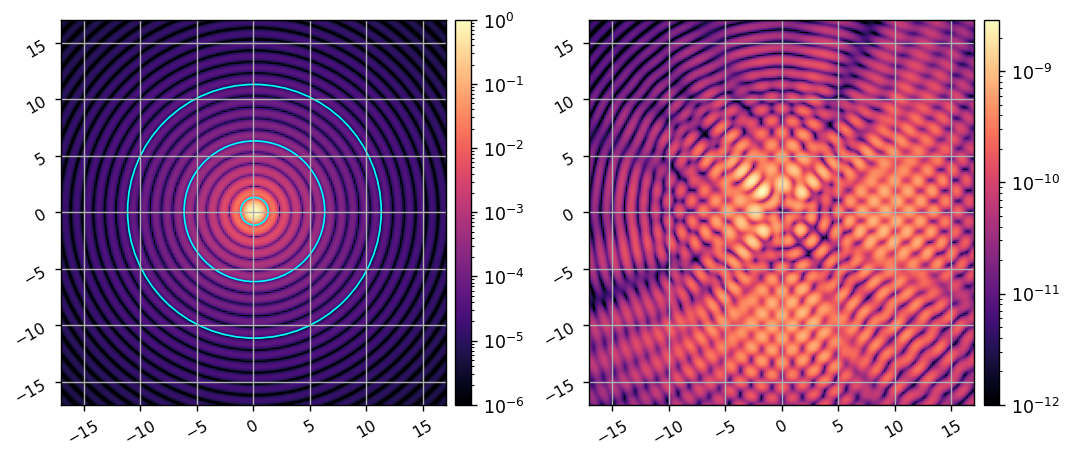

In [162]:
reload(cscoob)
reload(scoobpsf.props)
model = cscoob.CORO()
# model = cscoob.CORO(use_scc=True)
# model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

pup_ratio = model.dm_pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 10
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm(comm1+comm2)

model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2

imshow2(ref_psf/model.Imax_ref, im, lognorm=True, vmin1=1e-6, vmin2=1e-12,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+5, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+10, fill=False, color='cyan')])

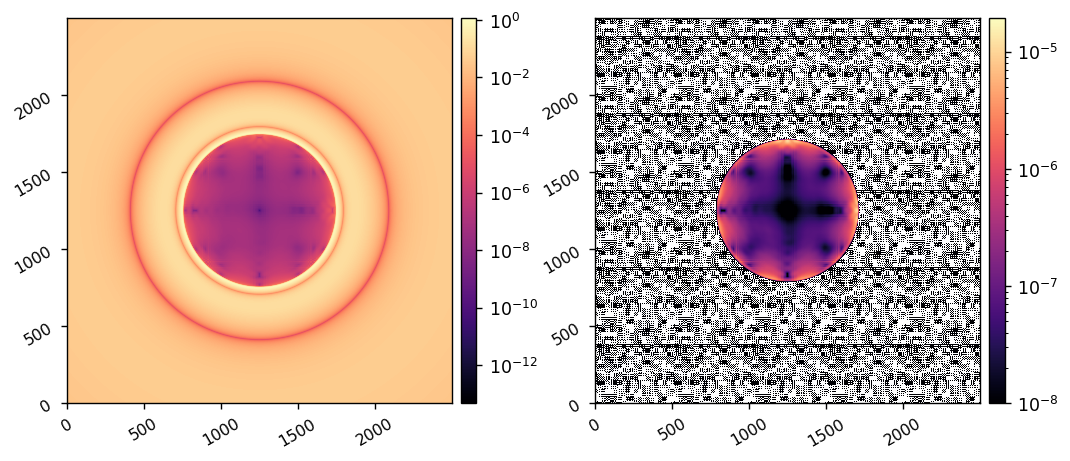

In [163]:
imshow2(xp.abs(wfs[-3])**2, xp.abs(wfs[-2])**2, lognorm=True, vmin2=1e-8)

In [91]:
model = cscoob.CORO()
model.WFE = WFE
model.Imax_ref = model.snap().max()
model.use_fpm = True
im = model.snap()

model = cscoob.CORO(use_scc=True)
model.WFE = WFE
model.Imax_ref = model.snap().max()
model.use_fpm = True
scc_im = model.snap()

imshow3(im, scc_im, im-scc_im, lognorm1=True, lognorm2=True, vmin1=1e-8, vmin2=1e-8)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


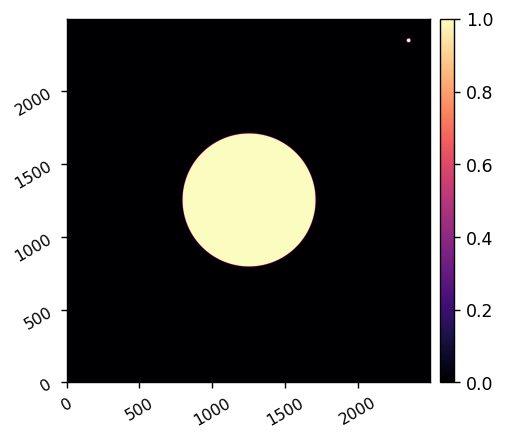

In [86]:
imshow1(model.LYOT)

In [22]:
model.psf_pixelscale_lamD

0.165825641025641

In [19]:
model.lyot_ratio

0.9148936170212765

In [2]:
reload(utils)
wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=3)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow3(mask, wfe_amp, wfe_opd, )
lina.utils.rms(wfe_opd[mask])


NameError: name 'npix' is not defined

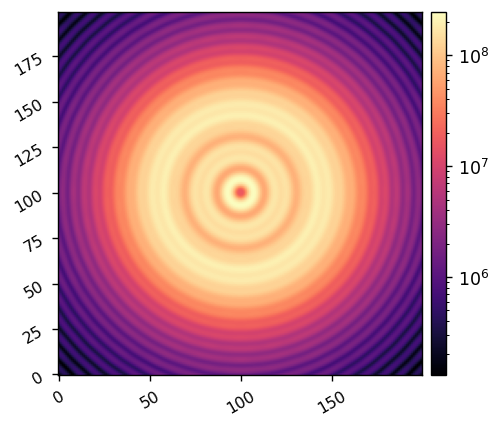

In [3]:
def get_scaled_coords(N, scale, center=True, shift=True):
    if center:
        cen = (N-1)/2.0
    else:
        cen = 0
        
    if shift:
        shiftfunc = xp.fft.fftshift
    else:
        shiftfunc = lambda x: x
    cy, cx = (shiftfunc(xp.indices((N,N))) - cen) * scale
    r = xp.sqrt(cy**2 + cx**2)
    return [cy, cx, r]

def get_fresnel_TF(dz, N, wavelength, fnum):
    '''
    Get the Fresnel transfer function for a shift dz from focus
    '''
    df = 1.0 / (N * wavelength * fnum)
    rp = get_scaled_coords(N,df, shift=False)[-1]
    return xp.exp(-1j*np.pi*dz*wavelength*(rp**2))

def mft_forward(pupil, psf_pixelscale_lamD):
    npix = pupil.shape[0]
    dx = 1.0 / npix
    Xs = (xp.arange(npix, dtype=float) - (npix / 2)) * dx

    du = psf_pixelscale_lamD
    Us = (xp.arange(npsf, dtype=float) - npsf / 2) * du

    xu = xp.outer(Us, Xs)
    vy = xp.outer(Xs, Us)

    My = xp.exp(-1j*2*np.pi*vy) 
    Mx = xp.exp(-1j*2*np.pi*xu) 

    return Mx@pupil@My

defocus = 2e-3*oversample**2
fnum = 100/8.6
tf = get_fresnel_TF(defocus, wfe.shape[0], wavelength.to_value(u.m), fnum)
image = xp.abs(mft_forward(tf*mask, psf_pixelscale_lamD*oversample))**2
imshow1(image, lognorm=True)

In [95]:
image.max()

array(268.26153665)

In [53]:
q

1.9575705096486888

In [15]:
Mx.shape

(512, 200)

In [7]:
xp.einsum

<function cupy.linalg._einsum.einsum(*operands, **kwargs)>

In [57]:
reload(utils)

<module 'scoobpsf.utils' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/utils.py'>

Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


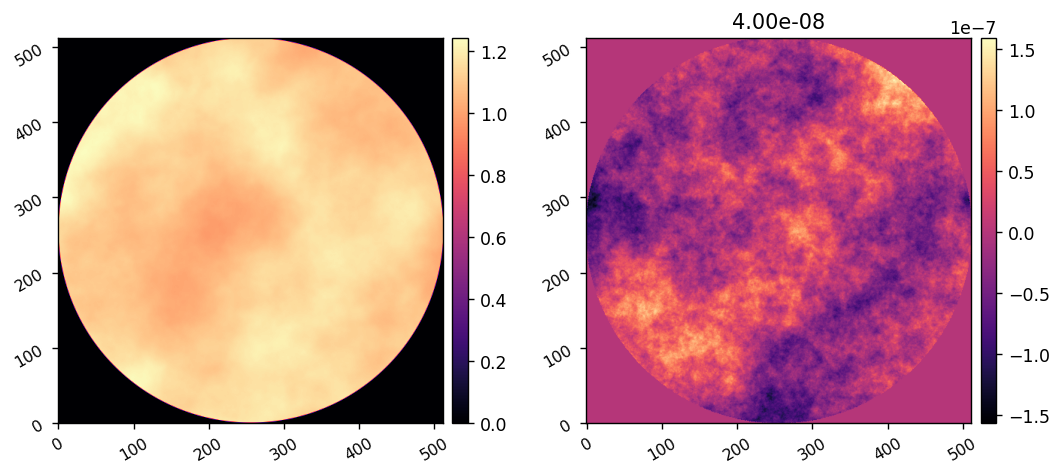

In [4]:
reload(cscoob)
reload(dm)

npix = 512
oversample = 16

model = cscoob.SCOOB(npix=npix, oversample=oversample, 
                     psf_pixelscale_lamD=psf_pixelscale_lamD)

wf = poppy.FresnelWavefront(beam_radius=npix*u.mm/2, npix=npix, oversample=1)
model.APERTURE = poppy.CircularAperture(radius=npix*u.mm/2).get_transmission(wf)

wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_seed=123, amp_seed=1234,
                                opd_index=2.75, amp_index=4,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=50)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow2(wfe_amp, wfe_opd, '', f'{lina.utils.rms(wfe_opd[mask]):.2e}')

# model.WFE = wfe

VORTEX = cscoob.make_vortex_phase_mask(model.make_grid(which='fpm', polar=True), charge=6, 
                                    #    singularity=20*u.um, 
                                       focal_length=500*u.mm, pupil_diam=model.dm_pupil_diam, wavelength=632.8*u.nm)

lyot_stop = poppy.CircularAperture(radius=0.9*npix*u.mm/2).get_transmission(wf)

# imshow3(model.APERTURE, model.LYOT, xp.angle(VORTEX), npix2=model.npix)

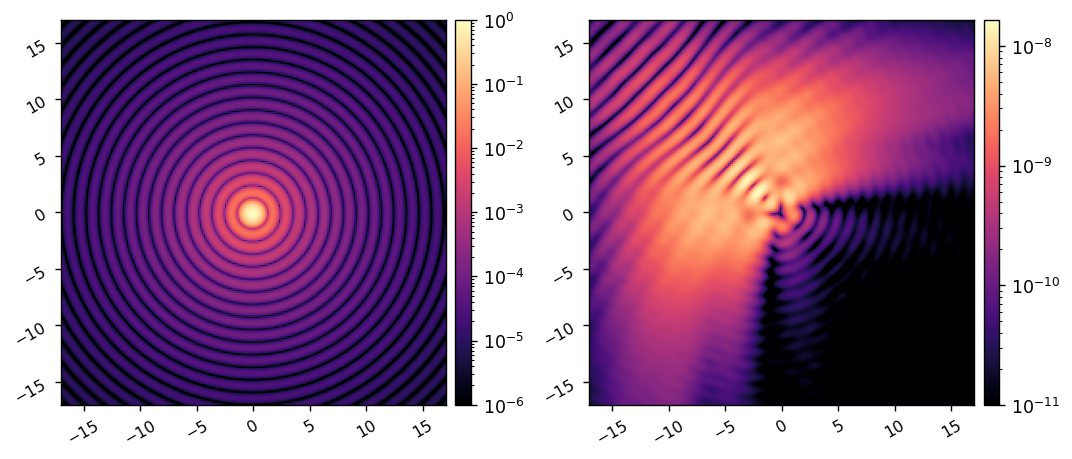

In [5]:
model.npsf = 200
model.FPM = None
model.LYOT = lyot_stop

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap()

model.Imax_ref = xp.max(ref_unocc_psf)
ni_psf = model.snap()

model.FPM = VORTEX

model.FIELDSTOP = None
# model.FIELDSTOP = model.focal_grid_pol[0]<15

ref_im = model.snap()

imshow2(ni_psf, ref_im, 
        pxscl=model.psf_pixelscale_lamD,
        vmin1=1e-6, vmin2=1e-11, lognorm=True)

In [14]:
lyot_pupil_diam

<Quantity 9.5 mm>

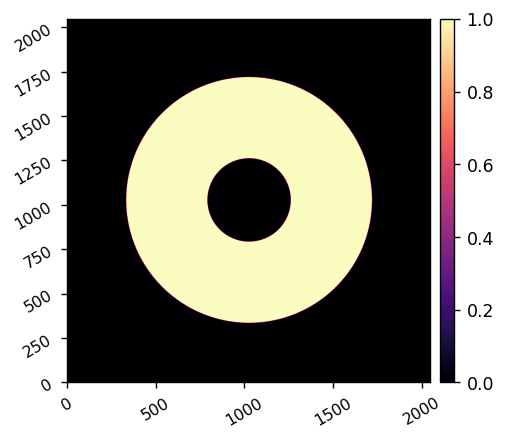

In [31]:
wf = poppy.FresnelWavefront(beam_radius=9.4*u.mm/2, npix=npix, oversample=4)
ref_lyot_stop = poppy.CircularAperture(radius=25.4*u.mm/2).get_transmission(wf) - poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(wf)

imshow1(ref_lyot_stop)

In [37]:
100/8.6 * 633e-9/2

3.6802325581395352e-06

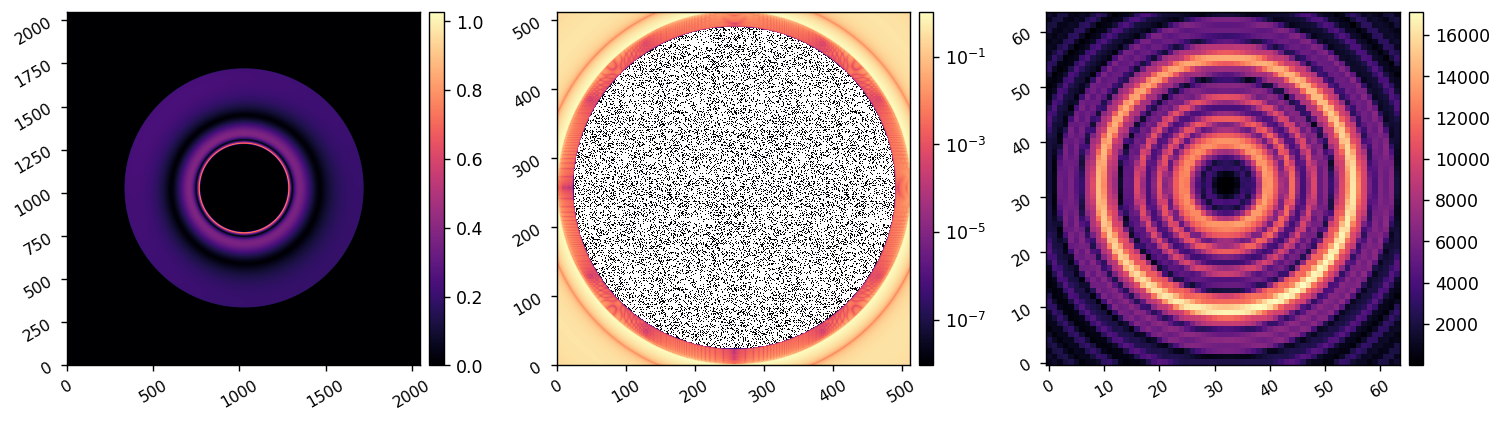

In [34]:
reload(cscoob)

model.use_llowfsc = True
model.llowfsc_fl = 200*u.mm
model.llowfsc_defocus = 1.75*u.mm

# model.FPM = None
# model.LYOT = xp.ones((model.npix,model.npix))

model.FPM = VORTEX
model.LYOT = ref_lyot_stop
wfs = model.propagate(return_all=True)

imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), xp.abs(wfs[-1]), 
        lognorm2=True,
        npix1=2048, npix2=npix,
        # lognorm2=True,
        )

In [140]:
!nvidia-smi

Mon May  6 16:54:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             62W /  300W |   41648MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
!kill 3409054

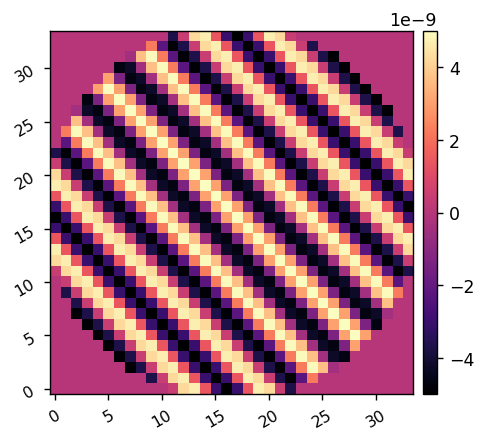

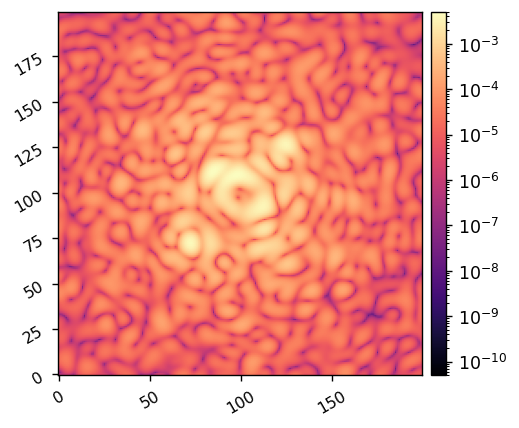

In [80]:
Nact = 34
xpp = xp.arange(-Nact//2, Nact//2) + 1/2
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-9
separation = 5
command = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/Nact)*model.dm_mask

imshow1(command)
model.set_dm(command)

im = model.snap()
imshow1(im, lognorm=True)

model.reset_dm()